In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from scipy import stats
import json
from scipy.stats import spearmanr
from grade_rank_calculation import calculate_grade_rank
from matplotlib import cm
from matplotlib.font_manager import FontProperties
import matplotlib.lines as mlines

In [2]:
# (1) read data

df = pd.read_pickle('RouteQualityData.pkl.zip', compression='zip')
df = df.where(pd.notnull(df), None)

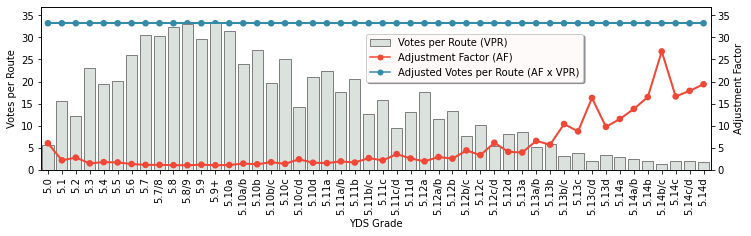

In [3]:
# (2) ARQI figure

YDS_grade_order = ['5.0', '5.1', '5.2', '5.3', '5.4', '5.5', '5.6', '5.7', '5.7/8', '5.8', '5.8/9', '5.9', '5.9+', '5.10a', 
                   '5.10a/b', '5.10b', '5.10b/c', '5.10c', '5.10c/d', '5.10d', '5.11a', '5.11a/b', '5.11b', '5.11b/c', 
                   '5.11c', '5.11c/d', '5.11d', '5.12a', '5.12a/b', '5.12b', '5.12b/c', '5.12c', '5.12c/d', '5.12d', '5.13a', 
                   '5.13a/b', '5.13b', '5.13b/c', '5.13c', '5.13c/d', '5.13d', '5.14a', '5.14a/b', '5.14b', '5.14b/c', '5.14c', 
                   '5.14c/d', '5.14d', '5.15a', '5.15c/d']

sport = df[df['type_string'] == 'sport'].copy()
SCplot = sport.groupby('nopm_YDS', as_index=False).agg({'num_votes': ['sum', 'count']})
SCplot['VPR'] = SCplot[('num_votes','sum')]/SCplot[('num_votes','count')]
SCplot['fac'] = 1.0/(SCplot['VPR']/max(SCplot['VPR']))
SCplot['AVPR'] = SCplot['fac'] * SCplot['VPR']

fig, ax0 = plt.subplots(figsize=(12,3))
ax0 = sns.barplot(data=SCplot, x='nopm_YDS', y='VPR', color='#DAE3DE',
                 order=YDS_grade_order[0:-2], edgecolor='grey', label='Votes per Route (VPR)')
ax1 = ax0.twinx()
sns.pointplot(data=SCplot, x='nopm_YDS', y='fac', ax=ax1, color='#F04737', linewidth=1.0,
              order=YDS_grade_order[0:-2], kind='point', scale=0.75)

sns.pointplot(data=SCplot, x='nopm_YDS', y='AVPR', ax=ax0, color='#338BA8',
              order=YDS_grade_order[0:-2], kind='line', scale=0.75)

lines0, labels0 = ax0.get_legend_handles_labels()

lines1 = [mlines.Line2D([], [], color='#F04737', marker='o', markersize=5)]
linesa = [mlines.Line2D([], [], color='#338BA8', marker='o', markersize=5)]

labels1 = ['Adjustment Factor (AF)']
labelsa = ['Adjusted Votes per Route (AF x VPR)']

lines = lines0 + lines1 + linesa
labels = labels0 + labels1 + labelsa

ax0.legend(lines, labels, loc=(0.485,0.54), shadow=True, facecolor='snow')

ax0.set_xticklabels(ax0.get_xticklabels(), rotation=90, horizontalalignment='center')
ax0.set(xlabel='YDS Grade', ylabel='Votes per Route')

ax0.set_ylim(0,37)
ax1.set_ylim(0,37)

ax1.set(ylabel='Adjustment Factor')
plt.savefig('figures/sport_votes_per_route.png', bbox_inches='tight', dpi=300)

/Users/Ryther/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-4-0cf5a1e5b136>:49: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(labels=[l[0] for l in gr_srccs], rotation=90, horizontalalignment='center')


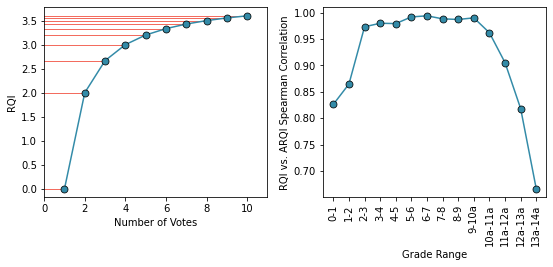

In [4]:
# (3) showing why ARQI and RQI are less similar for higher grades, needs to be cleaned up

def rqi(stars, nvotes):
    return stars * (1.0 - (1.0/nvotes))

gr_ranges = [('5.0', '5.1'), ('5.1', '5.2'), ('5.2', '5.3'), ('5.3', '5.4'), ('5.4', '5.5'), 
             ('5.5','5.6'), ('5.6','5.7'), ('5.7','5.8'), ('5.8','5.9'), ('5.9','5.10a'), 
             ('5.10a','5.11a'), ('5.11a','5.12a'), ('5.12a','5.13a'), ('5.13a','5.14a')]

gr_rank_ranges = [(calculate_grade_rank(r[0]), calculate_grade_rank(r[1])) for r in gr_ranges]
df_gr = df.copy()
df_gr['grade_range'] = ''
ind = df_gr.query('0 <= YDS_rank <= 13').index
df_gr['grade_range'].iloc[ind] = '5.0-5.1'

for gr, grr in zip(gr_ranges[1:], gr_rank_ranges[1:]):
    
    q = ' '.join([str(grr[0]), '<', 'YDS_rank', '<=', str(grr[1])])
    ind = df_gr.query(q).index
    df_gr.grade_range.iloc[ind] = '-'.join(gr)

df_gr = df_gr[df_gr['grade_range'] != ''].copy()
gr_srccs = []

for gr in gr_ranges:
    
    label = '-'.join([gr[0].split('.')[-1], gr[1].split('.')[-1]])
    sub = df_gr[df_gr['grade_range'] == '-'.join(gr)].copy()
    RQI = sub.RQI_median
    ARQI = sub.ARQI_median
    cor = spearmanr(RQI, ARQI)
    gr_srccs.append([label, cor[0]])
    
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(9,3.5))
plt.subplots_adjust(wspace=0.25)

nvotes = range(1,11)
rqis = [rqi(4.0, n) for n in nvotes]

ax0.set_xlim([0, 11])
for rqi, nv in zip(rqis, nvotes):
    ax0.axhline(rqi, xmin=0, xmax=nv/11.0, color='#F04737', linestyle='-', linewidth=0.8)

sns.lineplot(x=nvotes, y=rqis, linewidth=1.5, ax=ax0, color='#338BA8', marker='o', markersize=7, markeredgecolor='black')
ax0.set(xlabel='Number of Votes', ylabel='RQI')

sns.lineplot(x=[l[0] for l in gr_srccs], y=[l[1] for l in gr_srccs], ax=ax1, linewidth=1.5, marker='o', color='#338BA8', markersize=7, markeredgecolor='black')
ax1.set(xlabel='Grade Range', ylabel='RQI vs. ARQI Spearman Correlation')
ax1.set_xticklabels(labels=[l[0] for l in gr_srccs], rotation=90, horizontalalignment='center')

plt.savefig('figures/RQI_ARQI_correlation.png', bbox_inches='tight', dpi=300)

0.03448026302185645
0.196770124687248
0.3685821219577759
0.12952585761253904


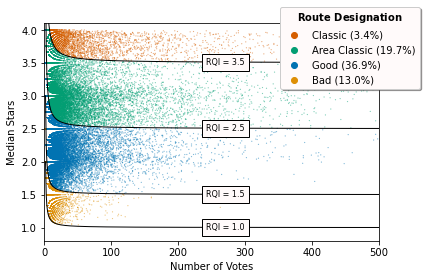

In [5]:
# (3) route designation figure

def rating_des(RQI):
    
    ranges = (('Bad (13.0%)', 1.0, 1.5), ('Good (36.9%)', 1.5, 2.5), ('Area Classic (19.7%)', 2.5, 3.5), ('Classic (3.4%)', 3.5, 100.0))
    
    for des in ranges:
        name, lo, hi = des
        
        if lo <= RQI < hi:
            return name

df['rating_des_label'] = df.apply(lambda row: rating_des(row['RQI_median']), axis = 1)

fig,ax = plt.subplots()

N = np.array(range(2, 1000))
classic = 3.5/(1-(1/N))
area_classic = 2.5/(1-(1/N))
good = 1.5/(1-(1/N))
bad = 1.0/(1-(1/N))

cp = sns.color_palette('colorblind')

sns.scatterplot(data=df, x='num_votes', y='median_rating', linewidth=0,
                hue='rating_des_label', palette='colorblind', s=1.5,
                alpha=0.50)

sns.lineplot(x=N, y=classic, color='black', linewidth=1.0)
sns.lineplot(x=N, y=area_classic, color='black', linewidth=1.0)
sns.lineplot(x=N, y=good, color='black', linewidth=1.0)
sns.lineplot(x=N, y=bad, color='black', linewidth=1.0)

plt.ylim(0.8,4.1)
plt.xlim(0,500)

prop = FontProperties()
fig.text(0.5, 2.432/3.3,'RQI = 3.5', fontsize=8,
         bbox=dict(facecolor='snow', edgecolor='black'))

fig.text(0.5, 1.674/3.3,'RQI = 2.5', fontsize=8,
         bbox=dict(facecolor='snow', edgecolor='black'))

fig.text(0.5, 0.918/3.3,'RQI = 1.5', fontsize=8,
         bbox=dict(facecolor='snow', edgecolor='black'), fontproperties=prop)

fig.text(0.5, 0.539/3.3,'RQI = 1.0', fontsize=8,
         bbox=dict(facecolor='snow', edgecolor='black'))

handles, labels = ax.get_legend_handles_labels()
labels, handles = zip(*sorted(zip(labels, handles), key=lambda t: t[0]))

labels = (labels[2], labels[0], labels[3], labels[1])
handles = (handles[2], handles[0], handles[3], handles[1])

ax.legend(handles, labels, loc='upper left', bbox_to_anchor=(0.69,1.1), 
          shadow=True, facecolor='snow', title='$\\bf{Route\ Designation}$')

ax.set(xlabel='Number of Votes', ylabel='Median Stars')

plt.savefig('figures/route_designations.png', bbox_inches='tight', dpi=300)

total = len(df.index)
print(len(df[df['rating_des_label'] == 'Classic (3.4%)'].index)/total)
print(len(df[df['rating_des_label'] == 'Area Classic (19.7%)'].index)/total)
print(len(df[df['rating_des_label'] == 'Good (36.9%)'].index)/total)
print(len(df[df['rating_des_label'] == 'Bad (13.0%)'].index)/total)

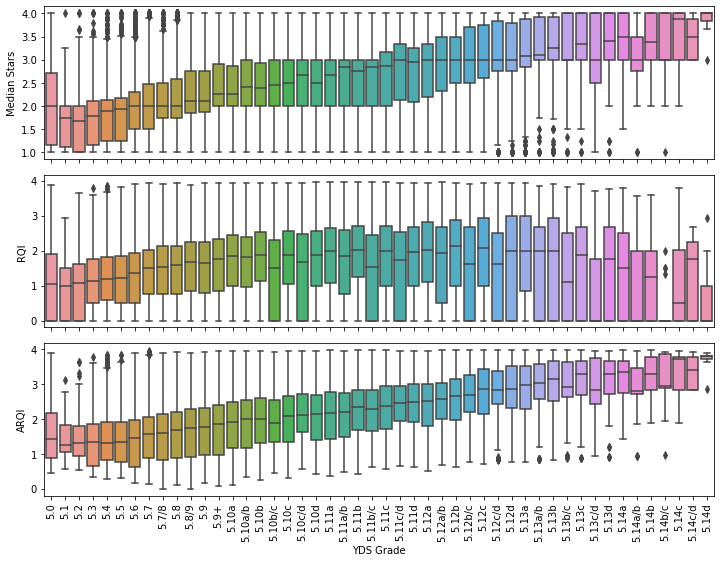

In [42]:
# (4) quality vs. grade boxplots

fig, (ax0, ax1, ax2) = plt.subplots(3, figsize=(12,9))

sns.boxplot(data=df, x='nopm_YDS', y='median_rating', order=YDS_grade_order[0:-2], ax=ax0)
sns.boxplot(data=df, x='nopm_YDS', y='RQI_median', order=YDS_grade_order[0:-2], ax=ax1)
sns.boxplot(data=df, x='nopm_YDS', y='ARQI_median', order=YDS_grade_order[0:-2], ax=ax2)

ax0.set(xlabel='', ylabel='Median Stars')
ax1.set(xlabel='', ylabel='RQI')
ax2.set(xlabel='YDS Grade', ylabel='ARQI')

ax0.set_xticklabels(['' for x in ax2.get_xticklabels()])
ax1.set_xticklabels(['' for x in ax2.get_xticklabels()])
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=90, horizontalalignment='center')

plt.subplots_adjust(hspace=0.1)
plt.savefig('figures/stars_RQI_ARQI_vs_grade.png', bbox_inches='tight', dpi=300)

In [ ]:
# (5) percent classics by grade

per_classics = []
for grade in YDS_grade_order:
    
    gr = df[df['nopm_YDS'] == grade]
    classics = gr[gr['rating_des_label'] == 'Classic (3.4%)']
    per = 100 * len(classics.index)/len(gr.index)
    per_classics.append([grade, per])

